### 假设已知十年国债收益率情形下验证论文结论
预期收益率8%，最大回撤12%

In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import fortitudo.tech as ft
import scipy.io as scio
import pypfopt as pfopt
from numba import njit
from datetime import datetime
import statsmodels.api as sm

In [69]:
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [70]:
start_date = '2007-01-01'
end_date = '2023-08-21'

In [71]:
A300 = pd.read_excel('A300_daily.xls').dropna()
A500 = pd.read_excel('A500_daily.xls').dropna()
SPX = pd.read_excel('SPX_daily.xls').dropna()
HSI = pd.read_excel('HSI_daily.xls').dropna()
AU9999 = pd.read_excel('AU9999_daily.xls').dropna()
CNbd = pd.read_excel('China_bond.xlsx').dropna()
CN10y = pd.read_excel('China_bond10y.xls').dropna()
SPX_VIX = pd.read_excel('SPX_VIX_daily.xls').dropna()

indices = {'A300':A300, 'A500':A500, 'SPX':SPX, 'HSI':HSI, 'AU9999':AU9999, 'CNbd': CNbd, 'CN10y': CN10y, 'SPX_VIX': SPX_VIX}
names = ['A300', 'A500', 'SPX', 'HSI', 'AU9999', 'CNbd', 'CN10y', 'SPX_VIX']
datalen = [index.shape[1] for name, index in indices.items()]

# 清洗数据
for name, index in indices.items():
    index = index.dropna()
    index = index[(index['交易时间'] >= start_date) & (index['交易时间'] <= end_date)]
    index = index.reset_index(drop=True)
    indices[name] = index   

#同步时间序列，直接删除不同市场区域不匹配的交易时间
for mg_name in names:
    for name, index in indices.items():
        if name== mg_name: continue
        datalen = index.shape[1]
        index = pd.merge(index, indices[mg_name], on='交易时间', how='inner', suffixes=('','_2')).iloc[:,:datalen]
        indices[name] = index
for name, index in indices.items():
    index.reset_index(drop=True, inplace=True)

In [72]:
# 因为重新同步了市场时间，所以需要重新计算涨跌幅
for name, index in indices.items():
    for i in range(1,index.shape[0]): #第0天不算了
        if name != 'CN10y':
            index.loc[i,'涨跌'] = index['收盘价'][i] - index['收盘价'][i-1]
            index.loc[i,'涨跌幅%'] = index.loc[i,'涨跌'] / index.loc[i-1,'收盘价'] * 100
        else:
            index.loc[i,'涨跌幅%'] = (index['收盘价'][i] - index['收盘价'][i-1]) / index.loc[i-1,'收盘价'] * 100
    index.fillna(0,inplace=True)

SPX_VIX = indices['SPX_VIX']
del indices['SPX_VIX']
names.pop()

CN10y = indices['CN10y']
#del indices['CN10y']
#names.pop()

In [73]:
pnls = np.array([[0] * indices['A300'].shape[0]])    # 把涨跌幅做成矩阵方便使用
names = []
for name, index in indices.items():
    names.append(name)
    pnls = np.r_[pnls, np.array(index['涨跌幅%']).reshape(1,-1)]
pnls = pd.DataFrame(pnls[1:].astype('float64').T,columns = names)
display(pnls)

,A300,A500,SPX,HSI,AU9999,CNbd,CN10y
0,1.275816,-0.142518,0.122829,-1.899785,-0.476964,0.000000,-1.910000
1,0.280104,2.714525,-0.608458,0.927314,-1.034178,0.081371,0.264638
2,2.830844,4.602142,0.222031,-0.898607,-2.051740,-0.045391,-0.329924
3,3.215016,2.155014,-0.051669,-0.656926,0.474889,0.108988,0.297915
4,2.539896,2.587916,0.194036,-1.657145,-0.071220,0.151142,0.396040
...,...,...,...,...,...,...,...
3815,-0.729793,0.058376,0.575038,-1.581321,0.153762,0.151371,-0.942685
3816,-0.243030,-0.625743,-1.155083,-1.025059,0.010966,0.218419,-1.560716
3817,-0.733179,-0.791918,-0.755544,-1.355194,0.173246,0.151834,-0.077340
3818,0.334361,0.705357,-0.771286,-0.014567,-0.019703,-0.030375,-0.425697


In [74]:
# 计算期望与协方差

Mu = pnls.mean(axis = 0)
Sigma = pnls.cov()
display(np.round(Mu,3))
display(np.round(pnls.corr(), 2))   # 相关系数矩阵
display(np.round(Sigma, 2))  # 协方差矩阵

A300      0.031
A500      0.051
SPX       0.038
HSI       0.009
AU9999    0.033
CNbd      0.016
CN10y     0.007
dtype: float64

,A300,A500,SPX,HSI,AU9999,CNbd,CN10y
A300,1.00,0.88,0.12,0.54,0.06,-0.08,0.02
A500,0.88,1.00,0.09,0.42,0.05,-0.06,0.02
SPX,0.12,0.09,1.00,0.26,0.00,-0.04,0.04
HSI,0.54,0.42,0.26,1.00,0.10,-0.09,0.03
AU9999,0.06,0.05,0.00,0.10,1.00,0.05,-0.03
CNbd,-0.08,-0.06,-0.04,-0.09,0.05,1.00,-0.22
CN10y,0.02,0.02,0.04,0.03,-0.03,-0.22,1.00


,A300,A500,SPX,HSI,AU9999,CNbd,CN10y
A300,2.99,2.98,0.28,1.50,0.10,-0.03,0.06
A500,2.98,3.82,0.24,1.31,0.09,-0.02,0.07
SPX,0.28,0.24,1.78,0.56,0.01,-0.01,0.08
HSI,1.50,1.31,0.56,2.55,0.16,-0.03,0.07
AU9999,0.10,0.09,0.01,0.16,1.05,0.01,-0.04
CNbd,-0.03,-0.02,-0.01,-0.03,0.01,0.04,-0.07
CN10y,0.06,0.07,0.08,0.07,-0.04,-0.07,2.33


In [75]:
@njit    #numba加速，需要明确定义数据类型
def price_MonteCarlo(sim_times:int, n_ptf:int, R:np.ndarray, p:np.ndarray) -> np.ndarray:
    '''
    只记录模拟结束的价格
    '''
    def rand_choice_nb(arr:np.ndarray, prob:np.ndarray) -> np.ndarray:
        """
        :param arr: A 1D numpy array of values to sample from.
        :param prob: A 1D numpy array of probabilities for the given samples.
        :return: A random sample from the given array with a given probability.
        """
        return arr[np.searchsorted(np.cumsum(prob), np.random.random(), side="right")]

    all_choice = np.arange(R.shape[0])
    
    sim_end_time = 20
    sim_series = np.zeros((sim_times, n_ptf))
    for i in range(sim_times):
        now_price = np.ones(n_ptf,dtype=np.float64)
        for t in range(sim_end_time):
            #scene = np.random.choice(all_choice, p = p.ravel()) # p parameter is not supported
            scene = rand_choice_nb(all_choice, p)
            drive = R[scene]
            now_price *= (1 + drive * 0.01)
        sim_series[i, :] = now_price
    return sim_series

@njit    #numba加速，需要明确定义数据类型
def path_MonteCarlo(sim_times:int, n_ptf:int, R:np.ndarray, p:np.ndarray) -> np.ndarray:
    '''
    记录整个模拟的价格路径
    '''
    def rand_choice_nb(arr:np.ndarray, prob:np.ndarray) -> np.ndarray:
        """
        :param arr: A 1D numpy array of values to sample from.
        :param prob: A 1D numpy array of probabilities for the given samples.
        :return: A random sample from the given array with a given probability.
        """
        return arr[np.searchsorted(np.cumsum(prob), np.random.random(), side="right")]

    all_choice = np.arange(R.shape[0])
    
    sim_end_time = 20
    sim_paths = np.zeros((sim_times, n_ptf,  sim_end_time))
    for i in range(sim_times):
        now_price = np.ones(n_ptf,dtype=np.float64)
        for t in range(sim_end_time):
            #scene = np.random.choice(all_choice, p = p.ravel()) # p parameter is not supported
            scene = rand_choice_nb(all_choice, p)
            drive = R[scene]
            now_price *= (1 + drive * 0.01)
            sim_paths[i, :, t] = now_price
    return sim_paths

In [76]:
def draw_ptf():
    fig = plt.figure(figsize = (12,10))

    time_series = np.arange(begin_time-adj_period, end_time+1,adj_period)
    port_series = opt1_port
    norm_prices = (prices[:, begin_time-adj_period:end_time+1:adj_period].T / prices[:, begin_time-adj_period]).T

    color = ['red', 'blue', 'orange', 'green', 'pink', 'magenta', 'grey', 'black']

    ax = fig.add_subplot(211)
    for i in range(3):
        ax.plot(time_series, norm_prices[i,:], label = names[i], color = color[i])
    ax.set_xlabel('Time')
    ax.set_ylabel('Indices')
    ax.legend(loc = 'upper left')

    ax2 = ax.twinx()
    for i in range(3):
        ax2.plot(time_series, port_series.iloc[i, :],'--', label = [*names, 'Cash'][i] + '(portion)', color = color[i])
    ax2.set_ylabel('Proportion')
    ax2.legend(loc = 'upper right')

    ax.grid()

    ax = fig.add_subplot(212)
    for i in range(3,n_ptf):
        ax.plot(time_series, norm_prices[i,:], label = names[i], color = color[i])
    ax.set_xlabel('Time')
    ax.set_ylabel('Indices')
    ax.legend(loc = 'upper left')

    ax2 = ax.twinx()
    for i in range(3,n_ptf + 1):
        ax2.plot(time_series, port_series.iloc[i, :],'--', label = [*names, 'Cash'][i] + '(portion)', color = color[i])
    ax2.set_ylabel('Proportion')
    ax2.legend(loc = 'upper right')

    ax.grid()
    
def draw_profit():
    color = ['red', 'blue', 'orange', 'green', 'pink', 'magenta', 'grey', 'black']
    norm_prices = (prices[:, begin_time-adj_period:end_time+1:adj_period].T / prices[:, begin_time-adj_period]).T

    portfo = np.array([.0,.0,.0,.0,.0,.0,.0,1])
    value_series = []
    for time in range(begin_time - adj_period, end_time+1, adj_period):
        # 简单起见，不考虑手续费，先把所有东西卖了然后再买入
        if time == end_time +  adj_period:
            prices_now = norm_prices[:,(time - (begin_time -  adj_period))//adj_period]
            for i in range(n_ptf):
                portfo[n_ptf] += portfo[i] * prices_now[i]
                portfo[i] = .0
            value_series.append(portfo[n_ptf])
            break
        prices_now = norm_prices[:,(time - (begin_time - adj_period))//adj_period]
        for i in range(n_ptf):
            portfo[n_ptf] += portfo[i] * prices_now[i]
            portfo[i] = .0
        ptf_portion = opt1_port.loc[:,time]
        value_series.append(portfo[n_ptf])

        for i in range(n_ptf):
            portfo[i] += portfo[n_ptf] * ptf_portion[i] *0.01 / prices_now[i]
        portfo[n_ptf] -= ptf_portion[:n_ptf].sum() * 0.01 * portfo[n_ptf]

    fig = plt.figure(figsize=(12,8))

    time_series = np.arange(begin_time- adj_period, end_time+1,20)
    plt.subplot(211)
    plt.ticklabel_format(style='plain')
    plt.xlabel('days')
    plt.ylabel('Value')
    for i in range(n_ptf):
        plt.plot(time_series, norm_prices[i,:], '--', label = names[i], color = color[i])
    plt.plot(time_series, value_series, label='My Portfolio')
    plt.legend()
    plt.grid()

    plt.subplot(212)
    plt.ticklabel_format(style='plain')
    plt.xlabel('days')
    plt.ylabel('Value')
    plt.plot(time_series, value_series, label='My Portfolio')
    plt.legend()
    plt.grid()

    time1 = datetime.strptime(str(indices['A300']['交易时间'][begin_time-adj_period])[:10],"%Y-%m-%d")
    time2 = datetime.strptime(str(indices['A300']['交易时间'][end_time])[:10],"%Y-%m-%d")
    duration_years = (time2 - time1).days / 365
    
    print('Start Date:', str(indices['A300']['交易时间'][begin_time-adj_period])[:10])
    print('End Date:', str(indices['A300']['交易时间'][end_time])[:10])
    print(f'Yearly Earning: {np.round((value_series[-1]**(1/duration_years) - 1) * 100,2)}%')
    down_window = 252
    roll_value = pd.DataFrame(value_series)
    roll_max = roll_value.rolling(down_window, min_periods=1).max()
    daily_drawdown = roll_value/roll_max - 1.0
    max_daily_drawdown = daily_drawdown.rolling(down_window, min_periods=1).min()
    print(f'Yearly Maximum Drawdown: {np.round(max_daily_drawdown.min()[0] * 100,2)}%')

In [77]:
def RSI(price, price_move, period = 12):
    rsi = np.array([0] * period)
    avg_gain = np.array([0] * period)
    avg_loss = np.array([0] * period)

    sub_move = price_move[1: period + 1]
    _avg_gain = np.sum(sub_move[sub_move >= 0])/period
    _avg_loss = np.sum(-sub_move[sub_move < 0])/period
    avg_gain = np.append(avg_gain, _avg_gain)
    avg_loss = np.append(avg_loss, _avg_loss)
    rsi = np.append(rsi, _avg_gain/(_avg_gain + _avg_loss) * 100)
    
    for i in range(period + 1, price.shape[0]):
        _avg_gain = (avg_gain[i - 1] * (period - 1) + max(price_move[i], 0)) / period
        _avg_loss = (avg_loss[i - 1] * (period - 1) + max(-price_move[i], 0)) / period
        avg_gain = np.append(avg_gain, _avg_gain)
        avg_loss = np.append(avg_loss, _avg_loss)
        rsi = np.append(rsi, _avg_gain/(_avg_gain + _avg_loss) * 100)
    return rsi

def momentum(prices, day_ago):
    diff = np.c_[prices[:, :day_ago], prices][:,:-day_ago]
    return (prices - diff) / diff

In [78]:
prices = []
for name, index in indices.items():
    prices.append(index['收盘价'])
prices = np.array(prices)

price_moves = []
for i in range(prices.shape[0]):
    price_moves.append([0])
    for j in range(1, prices.shape[1]):
        price_moves[i].append(prices[i][j] - prices[i][j - 1])
price_moves = np.array(price_moves)

In [79]:
begin_time = 247
end_time = 2997
adj_period = 20
n_ptf = pnls.shape[1]    # Portfolio number (no cash)

In [122]:
RSIs = []
for i in range(n_ptf):
    _RSI =  RSI(prices[i], price_moves[i], period = 14)
    RSIs.append(_RSI)
RSIs = np.array(RSIs)
RSIs

array([[ 0.        ,  0.        ,  0.        , ..., 37.60365455,
        39.66673391, 35.06126898],
       [ 0.        ,  0.        ,  0.        , ..., 33.38658045,
        38.45332158, 32.25298497],
       [ 0.        ,  0.        ,  0.        , ..., 40.99641115,
        37.31692943, 37.24804093],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., 56.46131252,
        56.16623485, 54.13501446],
       [ 0.        ,  0.        ,  0.        , ..., 81.54019748,
        79.33850558, 80.14731371],
       [ 0.        ,  0.        ,  0.        , ..., 26.33346678,
        24.69025479, 24.24589272]])

In [123]:
MTMs = momentum(prices, 120)

In [82]:
names = ['A300', 'A500', 'SPX', 'HSI', 'AU9999', 'CNbd', 'CN10y']
R_df = pd.DataFrame(data=pnls[0:begin_time], columns=names)
instrument_names = R_df.columns

print('原始数据')
# Print prior P&L stats
stats_prior = ft.simulation_moments(R_df)
display(stats_prior)

原始数据


,Mean,Volatility,Skewness,Kurtosis
A300,0.372544,2.561535,-1.098160,6.263918
A500,0.461828,2.890587,-1.129223,5.581408
SPX,-0.011650,1.103273,-0.390196,3.650630
HSI,0.081597,2.083357,-0.622045,12.659565
AU9999,0.123915,0.941834,-0.202003,4.196191
CNbd,-0.016929,0.224825,-0.269866,7.984207
CN10y,0.161790,2.326711,0.520808,6.446493


In [83]:
@njit  # 加速加速太慢了
def MC_p(this_ptf: np.ndarray, last_ptf: np.ndarray, paths: np.ndarray) -> float:
    '''
    计算Monte Carlo模拟的概率
    last_ptf: 上月持仓比例
    this_ptf: 本月持仓比例
    paths: 模拟的路径
    '''
    def maximum_accumulate(A):
        r = np.empty(len(A))
        t = -np.inf
        for i in range(len(A)):
            t = np.maximum(t, A[i])
            r[i] = t
        return r
    last_ptf /= last_ptf.sum()   # 持仓比例归一化
    this_ptf /= this_ptf.sum()
    
    trade_cost = np.abs(this_ptf - last_ptf).sum() * 0.005 / 2
    # the proportion of portfolio refers to the allocation of currency value
    # so there is no need to known the total money when calculating percentage
    
    cnt = 0   # 频率统计
    
    for i in range(paths.shape[0]):
        path = paths[i]
        value_series = path.T @ this_ptf[:-1] + this_ptf[-1] # 计算给定path在当月持仓下的价值变化（非现金资产 + 现金）
        p = np.argmax(maximum_accumulate(value_series) - value_series)
        if p == 0:
            max_drawdown = 0
        else:
            q = np.argmax(value_series[:p])
            max_drawdown = (value_series[p] - value_series[q]) / value_series[q]
        
        earning = value_series[-1] - 1
        if max_drawdown <= -0.006 or earning <= 0.01 + trade_cost:
            cnt += 1
    return cnt / paths.shape[0]

### 假设已知十年国债收益率

In [130]:
risk_free = 0.02

opt1_port = pd.DataFrame(np.array([2.,3.,1.,0.,44.,50.,0, 0.0],dtype=np.float64), index = [*names, 'Cash'], columns = [begin_time - adj_period])
for time in range(begin_time, end_time+1, adj_period):
    print(time)
    R_df = pd.DataFrame(data=pnls[0:time], columns=names)
    R = R_df.values
    
    S = R.shape[0]
    stats_prior = ft.simulation_moments(R_df)
    
    p = (np.ones((S, 1),dtype=np.float64) / S)    # Prior distribution
    A = np.ones((1,S),dtype=np.float64)
    A = np.vstack((A, R[:,6]))  # known 10y rate
    b = np.array(1.0,dtype=np.float64)
    b = np.append(b, (np.power((CN10y.iloc[time + 20]['收盘价'] / CN10y.iloc[time]['收盘价']), 1/20) - 1)*100)
    b = b.reshape(-1,1)
    q = ft.entropy_pooling(p, A, b)    # Post distribution
    q /= q.sum() # 缩放一下因为误差导致概率和不为1
    
    sim_end_time = 20
    sim_paths = path_MonteCarlo(10000, n_ptf, R,q)
    print('Sim ended.')
    
    cons = {'type': 'eq',#等式约束条件
         'fun' : lambda x: np.array([x.sum() - 1.0])}   # 资产比例之和为1
    bd = ((0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,0),(0,0))
    if (opt1_port.iloc[:,-1][-1] - 100.) < 1e-2:
        x0 = np.ones(n_ptf+1) /(n_ptf+1)
    else:
        x0 = opt1_port.iloc[:,-1]
    opt = scipy.optimize.minimize(MC_p, x0, method='SLSQP', bounds = bd, constraints=cons,\
                                  args=(opt1_port.values.T[-1] * 0.01, sim_paths), options = {'eps': 6e-2})
    print(f'P={np.round((1-opt.fun)*100,2)}%')
    _opt1_port = opt.x
    _opt1_port /= _opt1_port.sum()
    
    _opt1_port = opt.x * 100
    _opt1_port = pd.DataFrame(_opt1_port, index = [*names, 'Cash'], columns = [time])
    opt1_port = pd.concat([opt1_port, _opt1_port], axis = 1)

247
Sim ended.
P=16.03%
267
Sim ended.
P=18.48%
287
Sim ended.
P=16.61%
307
Sim ended.
P=16.27%
327
Sim ended.
P=15.12%
347
Sim ended.
P=12.97%
367
Sim ended.
P=12.11%
387
Sim ended.
P=12.76%
407
Sim ended.
P=18.37%
427
Sim ended.
P=0.09%
447
Sim ended.
P=14.06%
467
Sim ended.
P=0.1%
487
Sim ended.
P=0.06%
507
Sim ended.
P=13.38%
527
Sim ended.
P=0.14%
547
Sim ended.
P=0.18%
567
Sim ended.
P=0.17%
587
Sim ended.
P=0.26%
607
Sim ended.
P=13.28%
627
Sim ended.
P=16.83%
647
Sim ended.
P=0.14%
667
Sim ended.
P=13.72%
687
Sim ended.
P=0.12%
707
Sim ended.
P=0.22%
727
Sim ended.
P=13.88%
747
Sim ended.
P=19.35%
767
Sim ended.
P=19.96%
787
Sim ended.
P=0.38%
807
Sim ended.
P=0.27%
827
Sim ended.
P=15.42%
847
Sim ended.
P=20.08%
867
Sim ended.
P=19.65%
887
Sim ended.
P=18.41%
907
Sim ended.
P=19.38%
927
Sim ended.
P=18.23%
947
Sim ended.
P=19.36%
967
Sim ended.
P=19.32%
987
Sim ended.
P=17.93%
1007
Sim ended.
P=20.57%
1027
Sim ended.
P=19.09%
1047
Sim ended.
P=19.34%
1067
Sim ended.
P=19.72%
1

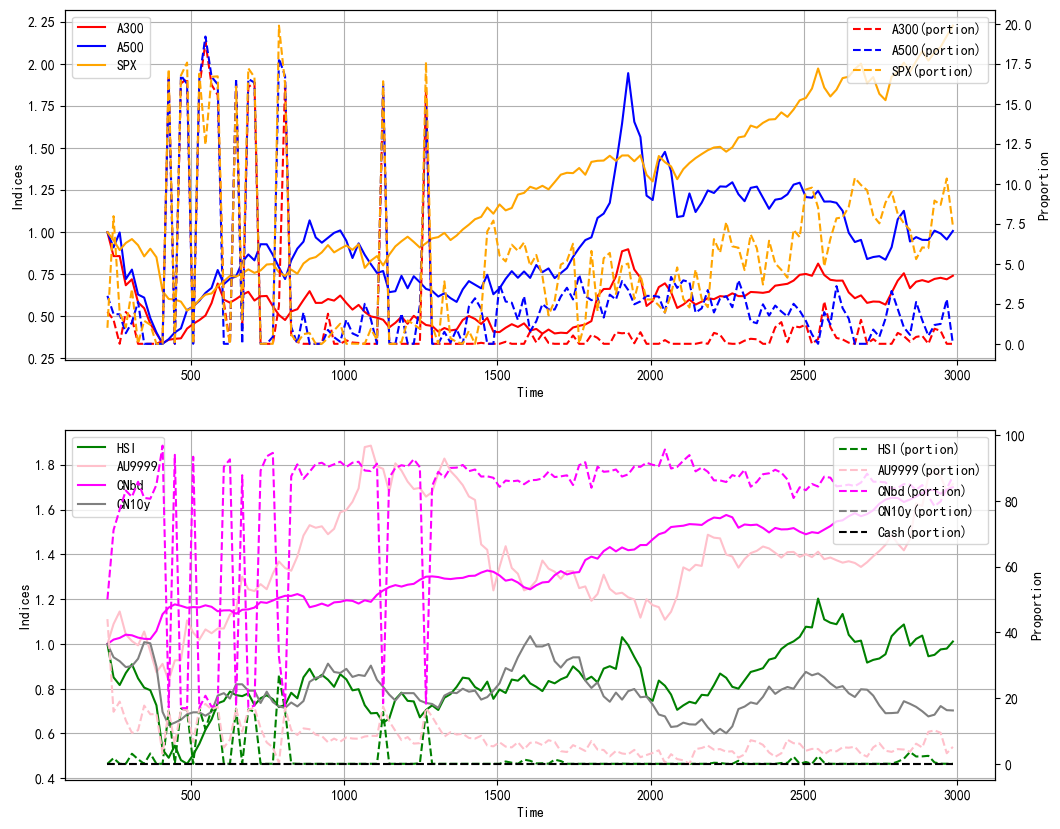

In [131]:
draw_ptf()

Start Date: 2008-01-02
End Date: 2020-01-10
Yearly Earning: 7.52%
Yearly Maximum Drawdown: -5.05%


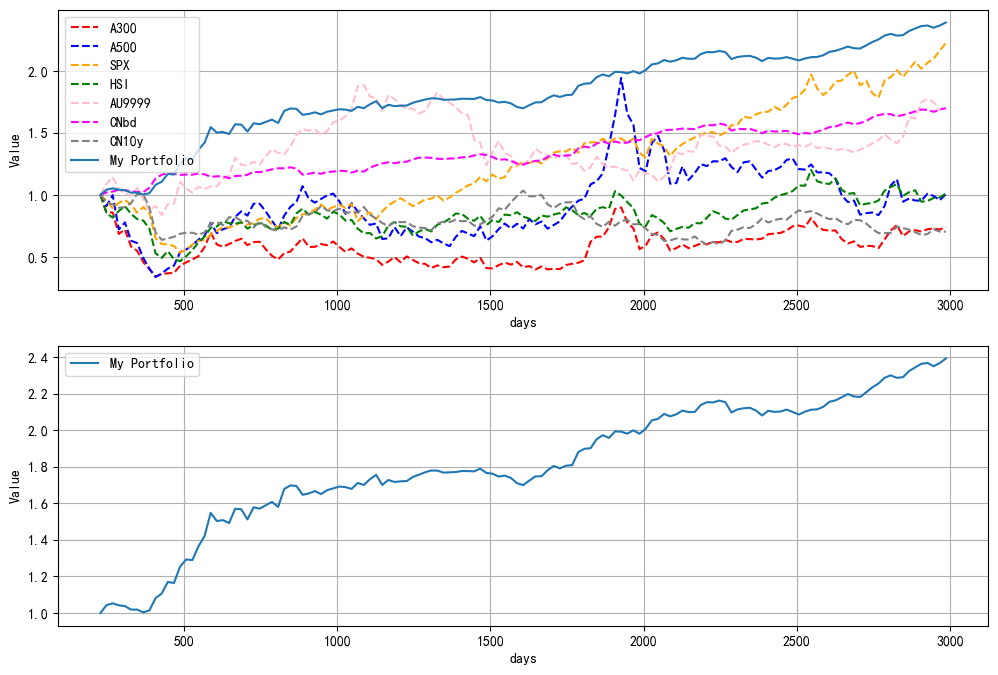

In [132]:
draw_profit()

In [136]:
risk_free = 0.02

opt1_port = pd.DataFrame(np.array([2.,3.,1.,0.,44.,50.,0, 0.0],dtype=np.float64), index = [*names, 'Cash'], columns = [begin_time - adj_period])
for time in range(begin_time, end_time+1, adj_period):
    print(time)
    R_df = pd.DataFrame(data=pnls[0:time], columns=names)
    R = R_df.values
    
    S = R.shape[0]
    stats_prior = ft.simulation_moments(R_df)
    
    p = (np.ones((S, 1),dtype=np.float64) / S)    # Prior distribution
    A = np.ones((1,S),dtype=np.float64)
    A = np.vstack((A, R[:,6]))  # known 10y rate
    b = np.array(1.0,dtype=np.float64)
    b = np.append(b, (np.power((CN10y.iloc[time + 20]['收盘价'] / CN10y.iloc[time]['收盘价']), 1/20) - 1)*100)
    b = b.reshape(-1,1)
    q = ft.entropy_pooling(p, A, b)    # Post distribution
    q /= q.sum() # 缩放一下因为误差导致概率和不为1
    
    sim_end_time = 20
    sim_paths = path_MonteCarlo(10000, n_ptf, R,q)
    print('Sim ended.')
    
    cons = {'type': 'eq',#等式约束条件
         'fun' : lambda x: np.array([x.sum() - 1.0])}   # 资产比例之和为1
    bd = ((0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,0),(0,0))
    if (opt1_port.iloc[:,-1][-1] - 100.) < 1e-2:
        x0 = np.ones(n_ptf+1) /(n_ptf+1)
    else:
        x0 = opt1_port.iloc[:,-1]
    opt = scipy.optimize.minimize(MC_p, x0, method='SLSQP', bounds = bd, constraints=cons,\
                                  args=(opt1_port.values.T[-1] * 0.01, sim_paths), options = {'eps': 6e-2})
    print(f'P={np.round((1-opt.fun)*100,2)}%')
    _opt1_port = opt.x
    _opt1_port /= _opt1_port.sum()
    
    _opt1_port = opt.x * 100
    _opt1_port = pd.DataFrame(_opt1_port, index = [*names, 'Cash'], columns = [time])
    opt1_port = pd.concat([opt1_port, _opt1_port], axis = 1)

247
Sim ended.
P=15.9%
267
Sim ended.
P=18.41%
287
Sim ended.
P=15.98%
307
Sim ended.
P=16.2%
327
Sim ended.
P=14.96%
347
Sim ended.
P=12.55%
367
Sim ended.
P=12.88%
387
Sim ended.
P=0.26%
407
Sim ended.
P=15.06%
427
Sim ended.
P=18.94%
447
Sim ended.
P=0.09%
467
Sim ended.
P=0.14%
487
Sim ended.
P=0.05%
507
Sim ended.
P=0.14%
527
Sim ended.
P=12.78%
547
Sim ended.
P=0.12%
567
Sim ended.
P=0.12%
587
Sim ended.
P=0.09%
607
Sim ended.
P=0.19%
627
Sim ended.
P=12.99%
647
Sim ended.
P=16.44%
667
Sim ended.
P=0.22%
687
Sim ended.
P=13.41%
707
Sim ended.
P=0.2%
727
Sim ended.
P=0.29%
747
Sim ended.
P=0.19%
767
Sim ended.
P=15.15%
787
Sim ended.
P=19.26%
807
Sim ended.
P=0.26%
827
Sim ended.
P=15.41%
847
Sim ended.
P=20.31%
867
Sim ended.
P=19.36%
887
Sim ended.
P=0.39%
907
Sim ended.
P=0.22%
927
Sim ended.
P=0.39%
947
Sim ended.
P=15.43%
967
Sim ended.
P=17.93%
987
Sim ended.
P=18.67%
1007
Sim ended.
P=20.52%
1027
Sim ended.
P=18.7%
1047
Sim ended.
P=19.34%
1067
Sim ended.
P=19.35%
1087
Sim 

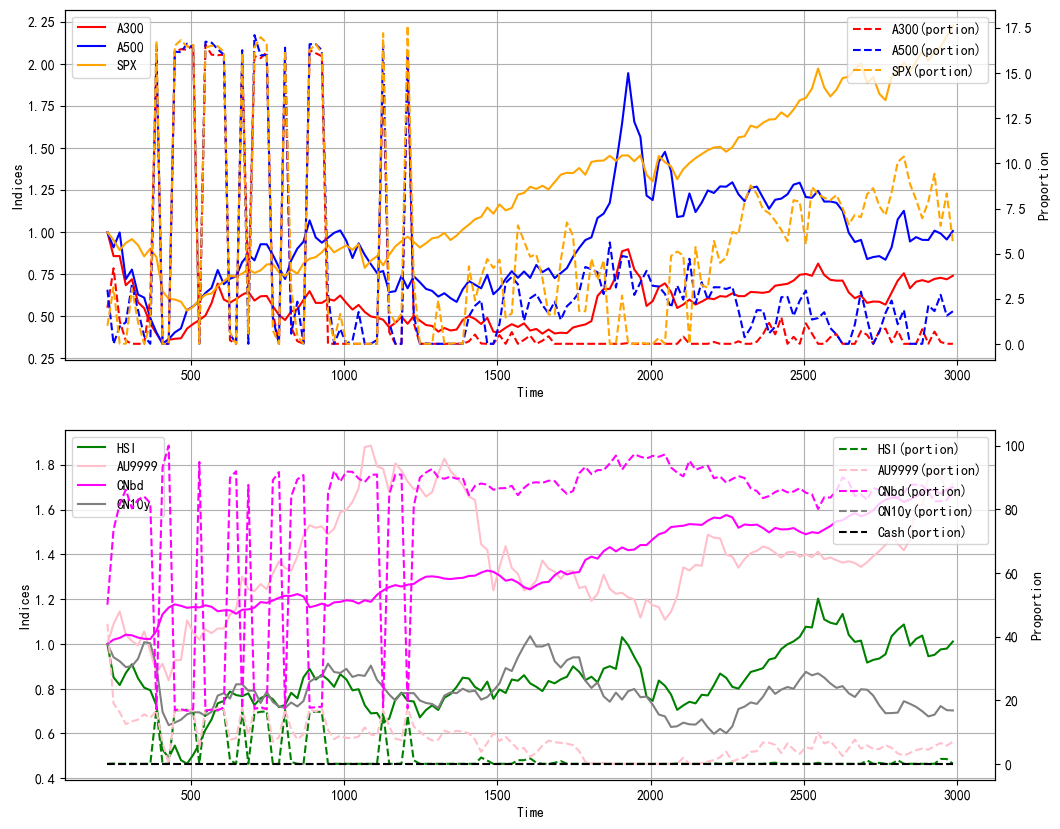

In [137]:
draw_ptf()

Start Date: 2008-01-02
End Date: 2020-01-10
Yearly Earning: 5.79%
Yearly Maximum Drawdown: -14.51%


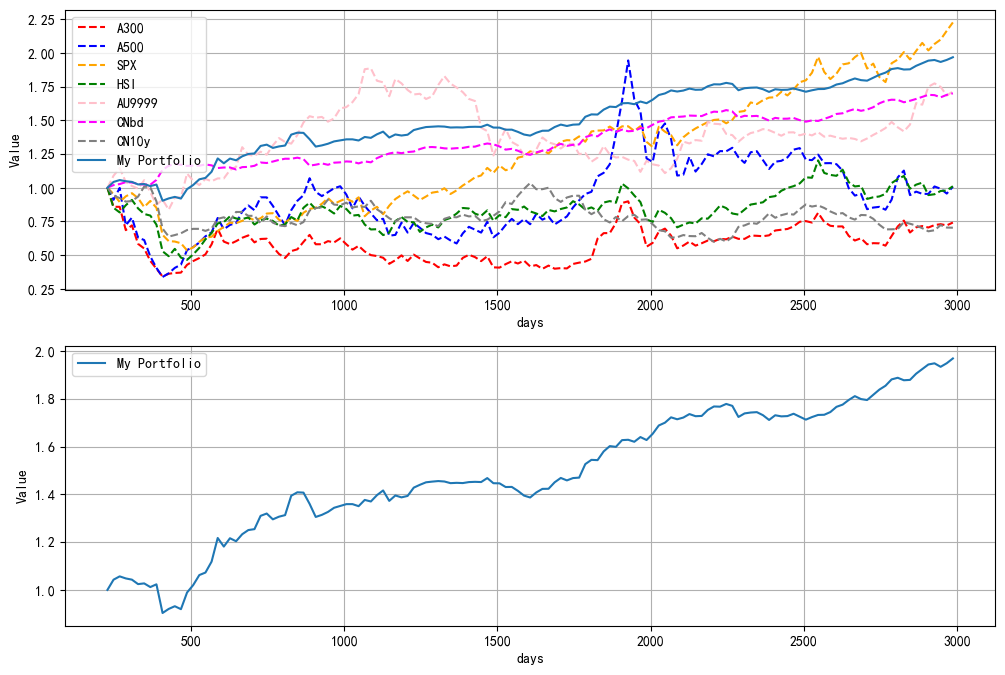

In [138]:
draw_profit()

### 加入技术指标

In [124]:
risk_free = 0.02

opt1_port = pd.DataFrame(np.array([0,0,0,0,0,0,0, 100.0],dtype=np.float64), index = [*names, 'Cash'], columns = [begin_time - adj_period])
for time in range(begin_time, end_time+1, adj_period):
    print(time)
    R_df = pd.DataFrame(data=pnls[0:time], columns=names)
    R = R_df.values
    
    S = R.shape[0]
    stats_prior = ft.simulation_moments(R_df)
    maxRSI = np.max(RSIs[:,time-adj_period:time],axis=1)
    minRSI = np.min(RSIs[:,time-adj_period:time],axis=1)
    view_mean = np.zeros(n_ptf)
    for i in range(n_ptf - 1):     # 债券单独考虑
        if maxRSI[i] >= 70:
            view_mean[i] -= 0.007
        if minRSI[i] <= 30:
            view_mean[i] += 0.005
    view_mean = stats_prior['Mean'] +view_mean
    
    p = (np.ones((S, 1),dtype=np.float64) / S)    # Prior distribution
    A = np.ones((1,S),dtype=np.float64)
    A = np.vstack((A, R[:, 0:n_ptf].T))
    A = np.vstack((A, (R[:, 2] - stats_prior['Mean']['SPX']) ** 2))    # volatility
    b = np.append(np.array(1.0,dtype=np.float64), view_mean)
    b = np.append(b,1/252* (SPX_VIX.loc[time, '收盘价']) ** 2) # volatility
    b = b.reshape(-1,1)
    q1 = ft.entropy_pooling(p, A, b)    # Post distribution
    
    view_mean = np.zeros(n_ptf)
    meanMTM = np.average(MTMs[:,time-adj_period:time], axis=1,weights = np.arange(1,2,0.05))
    for i in range(n_ptf - 1):    # 债券单独考虑
        if 0.2 > meanMTM[i] > 0.1:
            view_mean += 0.004
        elif -0.2 < meanMTM[i] < -0.1:
            view_mean -= 0.007
    view_mean = stats_prior['Mean'] +view_mean
    
    A = np.ones((1,S),dtype=np.float64)
    A = np.vstack((A, R[:, 0:n_ptf].T))
    A = np.vstack((A, (R[:, 2] - stats_prior['Mean']['SPX']) ** 2))    # volatility
    b = np.append(np.array(1.0,dtype=np.float64), view_mean)
    b = np.append(b,1/252* (SPX_VIX.loc[time, '收盘价']) ** 2) # volatility
    b = b.reshape(-1,1)
    q2 = ft.entropy_pooling(p, A, b)    # Post distribution
    
    A = np.ones((1,S),dtype=np.float64)
    A = np.vstack((A, R[:,6]))  # known 10y rate
    b = np.array(1.0,dtype=np.float64)
    b = np.append(b, (np.power((CN10y.iloc[time + 20]['收盘价'] / CN10y.iloc[time]['收盘价']), 1/20) - 1)*100)
    b = b.reshape(-1,1)
    q3 = ft.entropy_pooling(p, A, b)    # Post distribution
    
    q = q1 * 0.2 + q2 * 0.2 + q3 * 0.6
    q /= q.sum() # 缩放一下因为误差导致概率和不为1
    
    sim_end_time = 20
    sim_paths = path_MonteCarlo(10000, n_ptf, R,q)
    print('Sim ended.')
    
    cons = {'type': 'eq',#等式约束条件
         'fun' : lambda x: np.array([x.sum() - 1.0])}   # 资产比例之和为1
    bd = ((0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,0),(0,0))
    if (opt1_port.iloc[:,-1][-1] - 100.) < 1e-2:
        x0 = np.ones(n_ptf+1) /(n_ptf+1)
    else:
        x0 = opt1_port.iloc[:,-1]
    opt = scipy.optimize.minimize(MC_p, x0, method='SLSQP', bounds = bd, constraints=cons,\
                                  args=(opt1_port.values.T[-1] * 0.01, sim_paths), options = {'eps': 6e-2})
    print(f'P={np.round((1-opt.fun)*100,2)}%')
    _opt1_port = opt.x
    _opt1_port /= _opt1_port.sum()
    
    _opt1_port = opt.x * 100
    _opt1_port = pd.DataFrame(_opt1_port, index = [*names, 'Cash'], columns = [time])
    opt1_port = pd.concat([opt1_port, _opt1_port], axis = 1)

247
Sim ended.
P=12.02%
267
Sim ended.
P=20.61%
287
Sim ended.
P=15.38%
307
Sim ended.
P=14.76%
327
Sim ended.
P=13.69%
347
Sim ended.
P=12.58%
367
Sim ended.
P=11.78%
387
Sim ended.
P=11.37%
407
Sim ended.
P=14.04%
427
Sim ended.
P=0.09%
447
Sim ended.
P=0.05%
467
Sim ended.
P=0.06%
487
Sim ended.
P=0.15%
507
Sim ended.
P=13.84%
527
Sim ended.
P=0.17%
547
Sim ended.
P=0.12%
567
Sim ended.
P=0.17%
587
Sim ended.
P=14.03%
607
Sim ended.
P=0.16%
627
Sim ended.
P=13.3%
647
Sim ended.
P=16.32%
667
Sim ended.
P=17.99%
687
Sim ended.
P=17.78%
707
Sim ended.
P=0.16%
727
Sim ended.
P=14.05%
747
Sim ended.
P=19.45%
767
Sim ended.
P=20.12%
787
Sim ended.
P=17.88%
807
Sim ended.
P=0.3%
827
Sim ended.
P=0.17%
847
Sim ended.
P=14.52%
867
Sim ended.
P=20.79%
887
Sim ended.
P=21.46%
907
Sim ended.
P=21.51%
927
Sim ended.
P=22.4%
947
Sim ended.
P=21.7%
967
Sim ended.
P=19.79%
987
Sim ended.
P=19.61%
1007
Sim ended.
P=20.51%
1027
Sim ended.
P=19.27%
1047
Sim ended.
P=20.4%
1067
Sim ended.
P=19.02%
1087

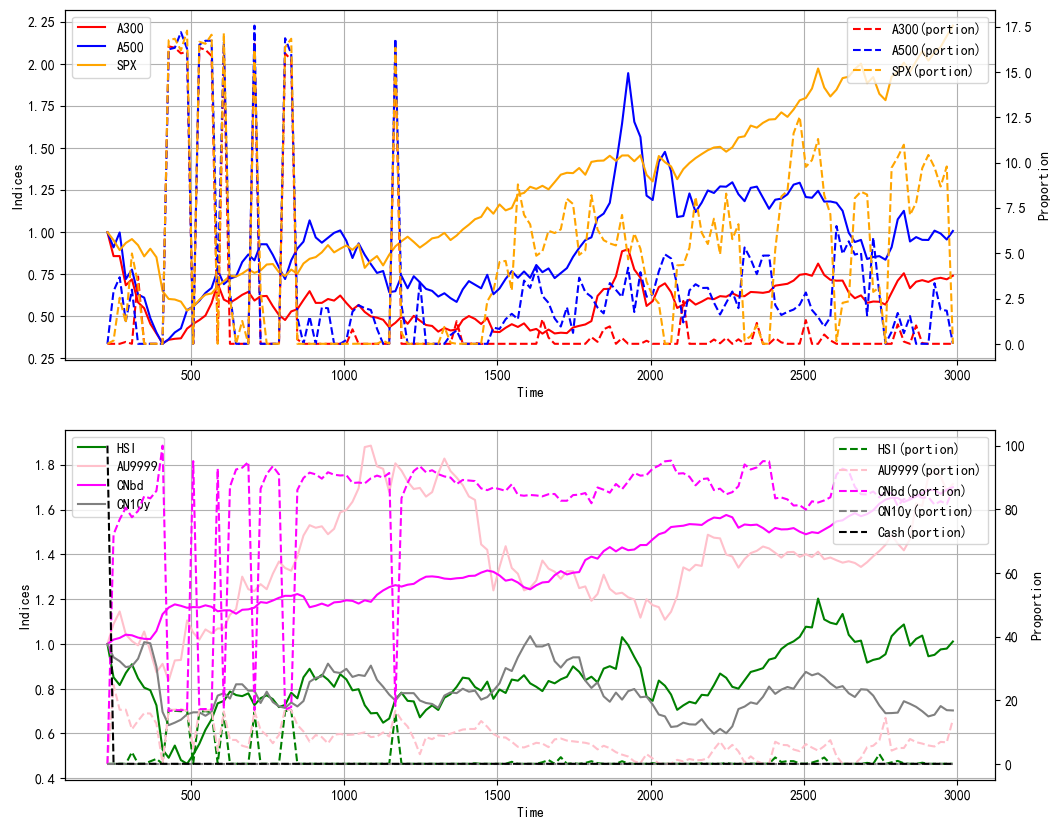

In [125]:
draw_ptf()

Start Date: 2008-01-02
End Date: 2020-01-10
Yearly Earning: 8.42%
Yearly Maximum Drawdown: -6.11%


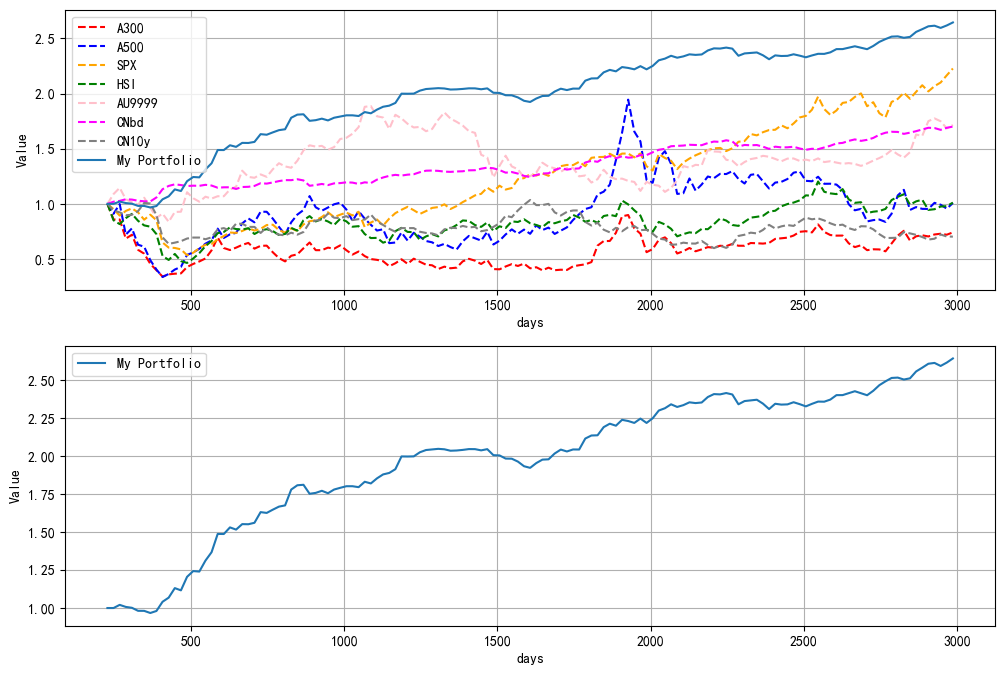

In [126]:
draw_profit()

In [109]:
risk_free = 0.02

opt1_port = pd.DataFrame(np.array([0,0,0,0,0,0,0, 100.0],dtype=np.float64), index = [*names, 'Cash'], columns = [begin_time - adj_period])
for time in range(begin_time, end_time+1, adj_period):
    print(time)
    R_df = pd.DataFrame(data=pnls[0:time], columns=names)
    R = R_df.values
    
    S = R.shape[0]
    stats_prior = ft.simulation_moments(R_df)
    maxRSI = np.max(RSIs[:,time-adj_period:time],axis=1)
    minRSI = np.min(RSIs[:,time-adj_period:time],axis=1)
    view_mean = np.zeros(n_ptf)
    for i in range(n_ptf - 1):     # 债券单独考虑
        if maxRSI[i] >= 70:
            view_mean[i] -= 0.007
        if minRSI[i] <= 30:
            view_mean[i] += 0.005
    view_mean = stats_prior['Mean'] +view_mean
    
    p = (np.ones((S, 1),dtype=np.float64) / S)    # Prior distribution
    A = np.ones((1,S),dtype=np.float64)
    A = np.vstack((A, R[:, 0:n_ptf].T))
    A = np.vstack((A, (R[:, 2] - stats_prior['Mean']['SPX']) ** 2))    # volatility
    b = np.append(np.array(1.0,dtype=np.float64), view_mean)
    b = np.append(b,1/252* (SPX_VIX.loc[time, '收盘价']) ** 2) # volatility
    b = b.reshape(-1,1)
    q1 = ft.entropy_pooling(p, A, b)    # Post distribution
    
    view_mean = np.zeros(n_ptf)
    meanMTM = np.average(MTMs[:,time-adj_period:time], axis=1,weights = np.arange(1,2,0.05))
    for i in range(n_ptf - 1):    # 债券单独考虑
        if 0.2 > meanMTM[i] > 0.1:
            view_mean += 0.004
        elif -0.2 < meanMTM[i] < -0.1:
            view_mean -= 0.007
    view_mean = stats_prior['Mean'] +view_mean
    
    A = np.ones((1,S),dtype=np.float64)
    A = np.vstack((A, R[:, 0:n_ptf].T))
    A = np.vstack((A, (R[:, 2] - stats_prior['Mean']['SPX']) ** 2))    # volatility
    b = np.append(np.array(1.0,dtype=np.float64), view_mean)
    b = np.append(b,1/252* (SPX_VIX.loc[time, '收盘价']) ** 2) # volatility
    b = b.reshape(-1,1)
    q2 = ft.entropy_pooling(p, A, b)    # Post distribution
    
    A = np.ones((1,S),dtype=np.float64)
    A = np.vstack((A, R[:,6]))  # known 10y rate
    b = np.array(1.0,dtype=np.float64)
    b = np.append(b, (np.power((CN10y.iloc[time + 20]['收盘价'] / CN10y.iloc[time]['收盘价']), 1/20) - 1)*100)
    b = b.reshape(-1,1)
    q3 = ft.entropy_pooling(p, A, b)    # Post distribution
    
    q = q1 * 0.2 + q2 * 0.2 + q3 * 0.6
    q /= q.sum() # 缩放一下因为误差导致概率和不为1
    
    sim_end_time = 20
    sim_paths = path_MonteCarlo(10000, n_ptf, R,q)
    print('Sim ended.')
    
    cons = {'type': 'eq',#等式约束条件
         'fun' : lambda x: np.array([x.sum() - 1.0])}   # 资产比例之和为1
    bd = ((0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,0),(0,0))
    if (opt1_port.iloc[:,-1][-1] - 100.) < 1e-2:
        x0 = np.ones(n_ptf+1) /(n_ptf+1)
    else:
        x0 = opt1_port.iloc[:,-1]
    opt = scipy.optimize.minimize(MC_p, x0, method='SLSQP', bounds = bd, constraints=cons,\
                                  args=(opt1_port.values.T[-1] * 0.01, sim_paths), options = {'eps': 6e-2})
    print(f'P={np.round((1-opt.fun)*100,2)}%')
    _opt1_port = opt.x
    _opt1_port /= _opt1_port.sum()
    
    _opt1_port = opt.x * 100
    _opt1_port = pd.DataFrame(_opt1_port, index = [*names, 'Cash'], columns = [time])
    opt1_port = pd.concat([opt1_port, _opt1_port], axis = 1)

247
Sim ended.
P=9.48%
267
Sim ended.
P=17.31%
287
Sim ended.
P=15.93%
307
Sim ended.
P=13.71%
327
Sim ended.
P=14.76%
347
Sim ended.
P=12.85%
367
Sim ended.
P=12.25%
387
Sim ended.
P=0.18%
407
Sim ended.
P=0.06%
427
Sim ended.
P=10.8%
447
Sim ended.
P=0.05%
467
Sim ended.
P=0.06%
487
Sim ended.
P=0.06%
507
Sim ended.
P=0.1%
527
Sim ended.
P=0.17%
547
Sim ended.
P=0.09%
567
Sim ended.
P=13.64%
587
Sim ended.
P=0.23%
607
Sim ended.
P=12.7%
627
Sim ended.
P=17.88%
647
Sim ended.
P=16.54%
667
Sim ended.
P=18.53%
687
Sim ended.
P=16.91%
707
Sim ended.
P=18.25%
727
Sim ended.
P=0.26%
747
Sim ended.
P=0.33%
767
Sim ended.
P=13.72%
787
Sim ended.
P=18.93%
807
Sim ended.
P=0.2%
827
Sim ended.
P=0.27%
847
Sim ended.
P=15.29%
867
Sim ended.
P=21.75%
887
Sim ended.
P=19.55%
907
Sim ended.
P=0.36%
927
Sim ended.
P=14.82%
947
Sim ended.
P=18.45%
967
Sim ended.
P=18.75%
987
Sim ended.
P=18.99%
1007
Sim ended.
P=19.68%
1027
Sim ended.
P=19.17%
1047
Sim ended.
P=20.69%
1067
Sim ended.
P=18.74%
1087
Si

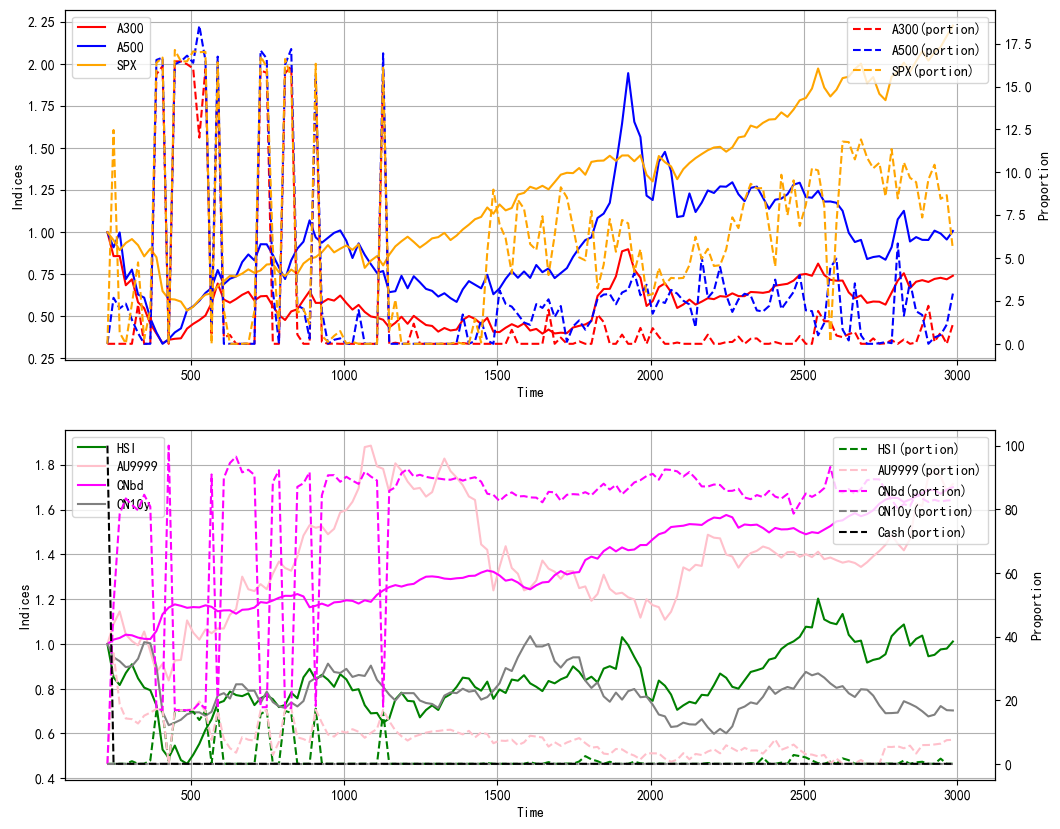

In [110]:
draw_ptf()

Start Date: 2008-01-02
End Date: 2020-01-10
Yearly Earning: 4.14%
Yearly Maximum Drawdown: -15.34%


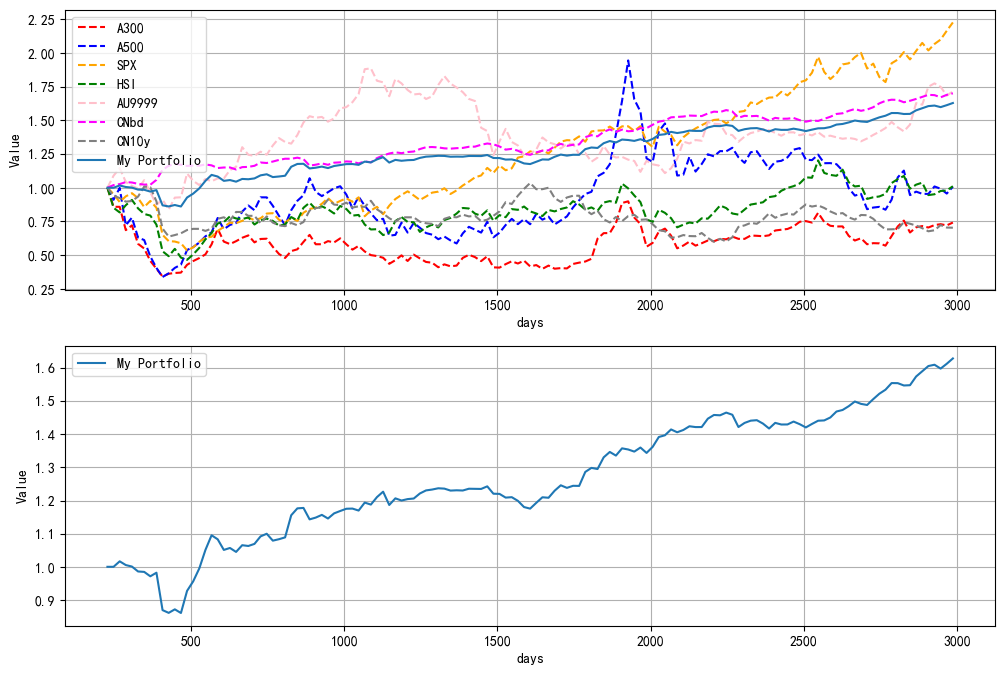

In [111]:
draw_profit()